# Задачи, цели работы


## Цель работы


Цель этой лабораторной работы - изучить и применить готовые библиотеки для оптимизации на Python, в частности, PyTorch и различные методы оптимизации из SciPy. Также, требуется сравнить эффективность работы этих методов с нашими реализациями из прошлых работ.

## Задачи для достижения указанной цели

1. Изучить использование вариантов SGD (torch.optim) из PyTorch. Исследовать их эффективность и сравнить с собственными реализациями из предыдущих работ.
2. Изучить использование готовых методов оптимизации из SciPy (scipy.optimize.minimize, scipy.optimize.least_squares). Исследовать их эффективность и сравнить с собственными реализациями из предыдущих работ.
3. Реализовать использование PyTorch для вычисления градиента и сравнить его с другими подходами.
4. Исследовать, как задание границ изменения параметров влияет на работу методов из SciPy.
5. Исследовать использование линейных и нелинейных ограничений при использовании scipy.optimize.minimize из SciPy. Рассмотреть случаи, когда минимум находится на границе заданной области и когда он расположен внутри.
6. Подготовить отчет, содержащий описание реализованных алгоритмов, реализацию, необходимые тесты и таблицы. Отчет должен также включать анализ результатов, преимуществ и ограничений методов.

# Ход работы

## Подготовка среды, определение полезных функций

### В предыдущих сериях:

In [1]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import profiler
import descent
import regression
import visualization
import dataset

In [2]:
plt.rcParams["figure.figsize"] = (10, 10)
np.set_printoptions(precision=2, suppress=False)

### Dataset

В качестве задачи Least Squares мы будем использовать модель нелинейной регрессии из прошлой работы на базе датасета изменения погоды от Яндекса:

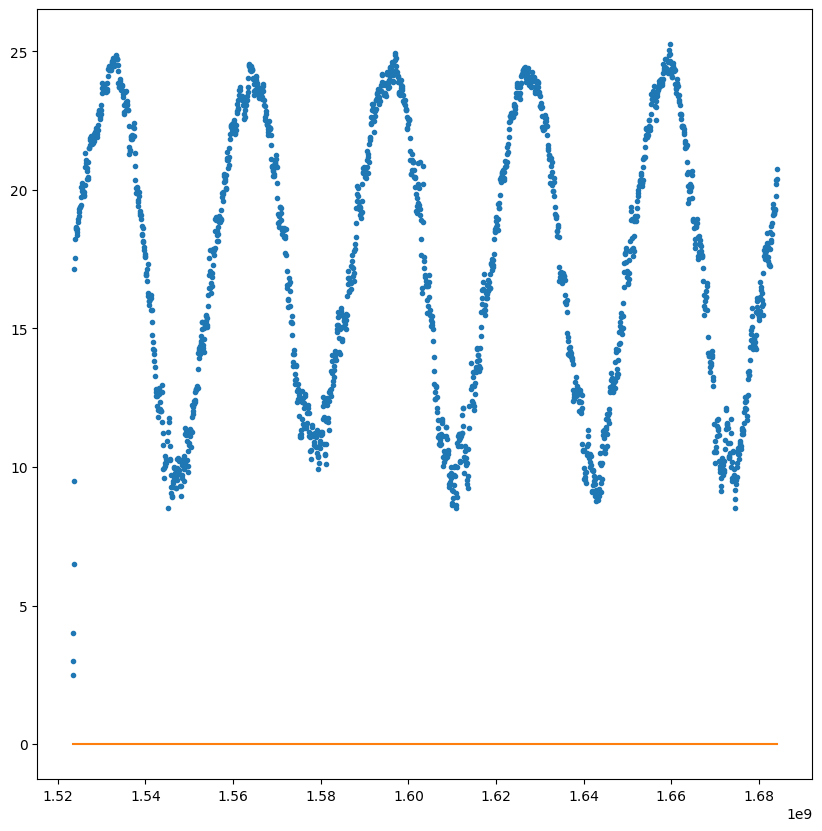

In [3]:
data = dataset.get_data()
data_weather = dataset.get_data_weather()
visualization.visualize_regression([0.0], *data_weather)

Как видим, данные вполне периодичны. Попробуем их описать синусом:

Определим модель как
$$M(x, W) = W_1 + W_2 \cdot x + W_3 \cdot x^2 + W_4 \cdot x^3 + W_5 \cdot \sin (x \cdot W_6 + W_7)$$
Тогда Loss-функция будет выглядеть как
$$
f(W) = \sum_{i\in{DATA_x}} (DATA_{yi} - M(i))^2
$$

In [4]:
f_weather, f_weather_chunk = dataset.get_nonlinear_loss_func(*data_weather)

В качестве квадратичной задачи для градиентного спуска, будем использовать Loss-функцию линейной регрессии из работы №2. Она построена на базе датасета успеваемости студентов в зависимости от количества часов подготовки:

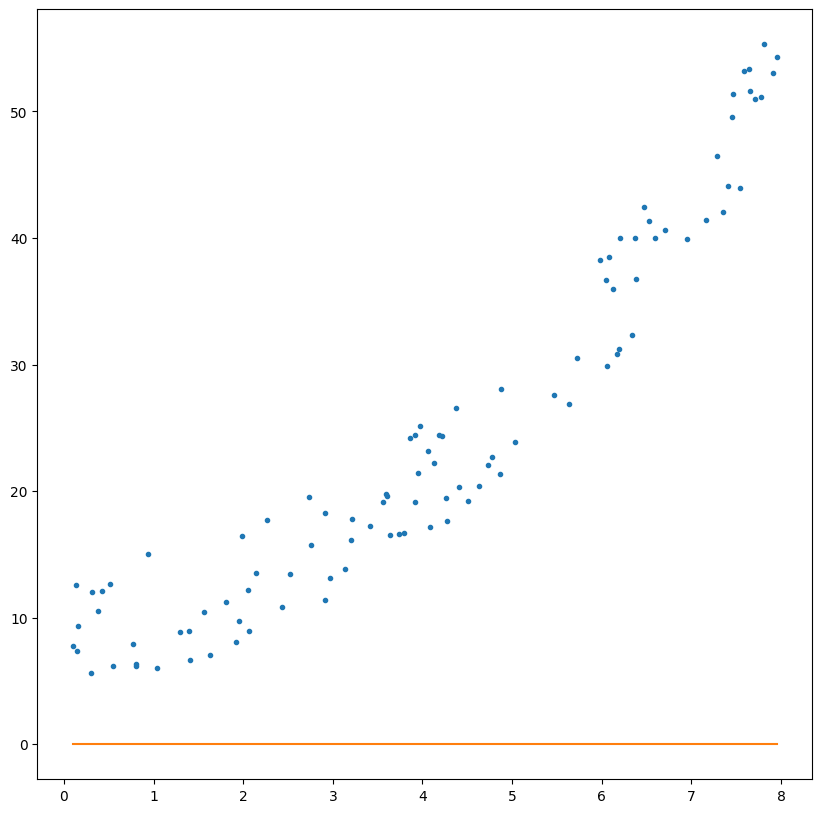

In [5]:
f_stud, f_stud_chunk = dataset.get_linear_loss_func(*data)
visualization.visualize_regression([0.0], *data)

### Rosenbrock function

Она пригодится для сравнения работы различных алгоритмов оптимизации

Определим её следующим образом:
$$
f(x, y) = (1 - x)^2 + 100(y - x^2)^2
$$
Это нелинейная функция, будем использовать её минимизировать для демонстрации работы некоторых методов в будущем.

## Задание 1. Исследование реализации SGD из Pytorch

В прошлых работах были реализованы методы:
- Sgd
- Sgd with momentum
- Rmsprop
- Adagrad
- Adam

In [6]:
from descent import (
    minibatch_descent,
    nesterov_minibatch_descent,
    rmsprop_minibatch_descent,
    adagrad_minibatch_descent,
    adam_minibatch_descent,
)

### Функция Розенброка

#### Наша реализация

Глобальный минимум: [1.0, 1.0]


Метод  Всего точек                                     Минимум в   
0      Adam         1001      [1.3210390744438398, 1.7270224693264853]  \
1       SGD         1001  [0.0012623699224284524, -3.4538746885806404]   
2  Nesterov         1001  [0.06923394154975764, 0.0035740033885314918]   
3   RMSProp         1001      [0.8501824924038699, 0.7250194172972521]   
4   Adagrad         1001      [-1.8202067257835577, 3.302279650357234]   

   Значение в точке минимума  
0                   0.135906  
1                1193.923614  
2                   0.866474  
3                   0.022933  
4                   7.965388

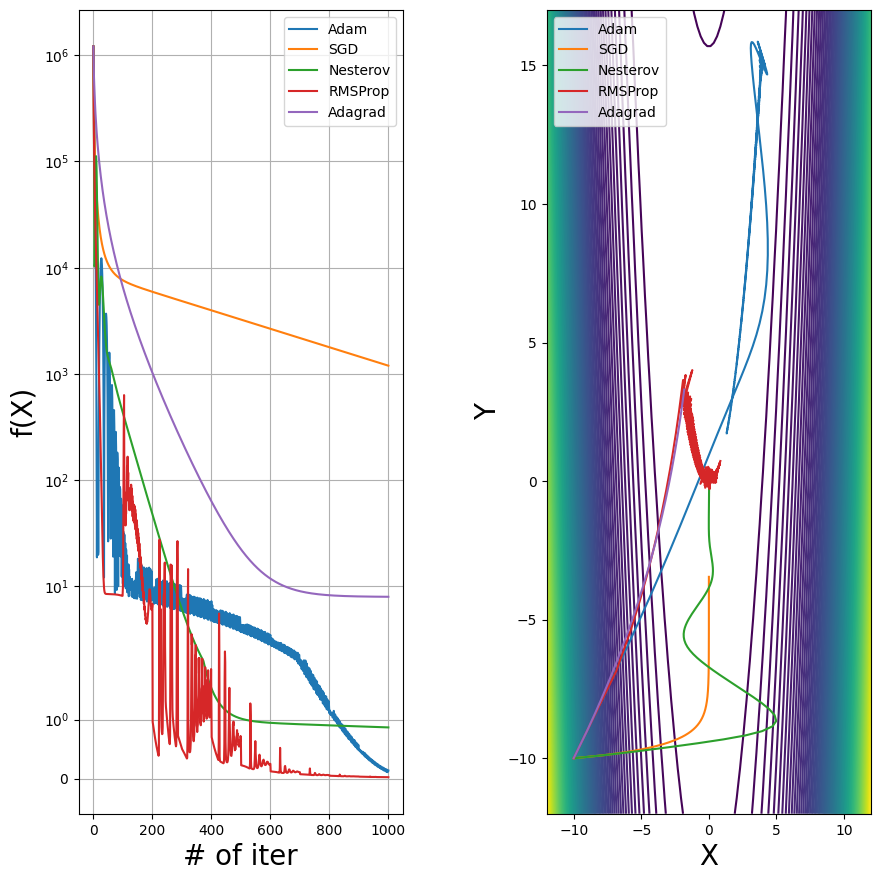

In [7]:
from funcs import squared, f_rosenbrock, f_rosenbrock_chunk

print("Глобальный минимум: [1.0, 1.0]")
visualization.visualize_multiple_descent_2args(
    {
        "Adam": adam_minibatch_descent(
            f=squared(f_rosenbrock_chunk()),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            decay=descent.step_decay(1.0, 0.8, 100),
            n_epochs=1000,
            tol=0.01,
            betta1=0.9,
            betta2=0.9,
        ),
        "SGD": minibatch_descent(
            f=squared(f_rosenbrock_chunk()),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.constant_lr_decay(0.00001),
            n_epochs=1000,
            tol=0.01,
        ),
        "Nesterov": nesterov_minibatch_descent(
            f=squared(f_rosenbrock_chunk()),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.constant_lr_decay(0.0001),
            n_epochs=1000,
            tol=0.01,
            alpha=0.9,
        ),
        "RMSProp": rmsprop_minibatch_descent(
            f=squared(f_rosenbrock_chunk()),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.step_decay(1.0, 0.5, 100),
            n_epochs=1000,
            tol=0.01,
            alpha=0.9,
        ),
        "Adagrad": adagrad_minibatch_descent(
            f=squared(f_rosenbrock_chunk()),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.constant_lr_decay(1.0),
            n_epochs=1000,
            tol=0.01,
        ),
    },
    f_rosenbrock,
    print_points=True,
)

#### Pytorch

Подготовим аналогичные методы в реализации PyTorch

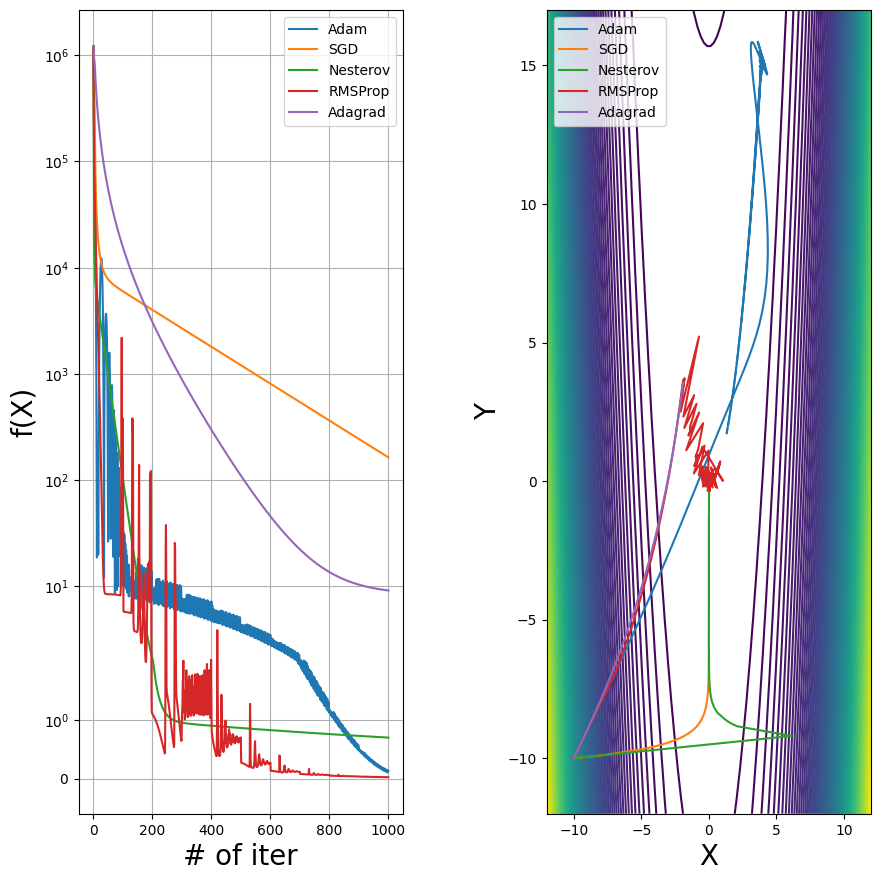

In [8]:
import torch
import descent

visualization.visualize_multiple_descent_2args(
    {
        "Adam": descent.torch_descent(
            torch.optim.Adam(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=1.0,
                betas=(0.9, 0.9),
            ),
            f_rosenbrock,
            1000,
            torch.optim.lr_scheduler.StepLR,
            100,  # Step size
            0.8,  # Gamma
        ),
        "SGD": descent.torch_descent(
            torch.optim.SGD(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=0.00001,
            ),
            f_rosenbrock,
            1000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "Nesterov": descent.torch_descent(
            torch.optim.SGD(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=0.0001,
                momentum=0.1,
                nesterov=True,
            ),
            f_rosenbrock,
            1000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "RMSProp": descent.torch_descent(
            torch.optim.RMSprop(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=1.0,
                alpha=0.9,
            ),
            f_rosenbrock,
            1000,
            torch.optim.lr_scheduler.StepLR,
            100,  # Step size
            0.5,  # Gamma
        ),
        "Adagrad": descent.torch_descent(
            torch.optim.Adagrad(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=1.0,
            ),
            f_rosenbrock,
            1000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
    },
    f_rosenbrock,
)

Ввиду обусловленности представленной функции, обычный стохастический спуск так и не удалось адекватно стабилизировать, он начал сходиться только при чрезвычайно маленьком Learning Rate (1e-5). Каждое его улучшение помогает улучшить и ускорить сходимость, что отлично видно на графиках, учитывая подобранный Learning Rate для каждого из методов.

### Линейная регрессия

#### Наша реализация

Метод  Всего точек                                 Минимум в   
0      Adam        50001  [1.7900259675705141, 5.5797749701448565]  \
1  Nesterov        50001   [1.0922781312566336, 5.713317371871113]   
2   RMSProp        50001    [1.208325616289877, 5.719454864839602]   
3   Adagrad        50001   [1.2342994308949669, 5.703273932067454]   
4       SGD        50001   [1.0651846241518956, 5.719850197235003]   

   Значение в точке минимума  
0                  22.870081  
1                  22.793382  
2                  22.806310  
3                  22.795059  
4                  22.795439

Elapsed:  130.75677037239075 sec.


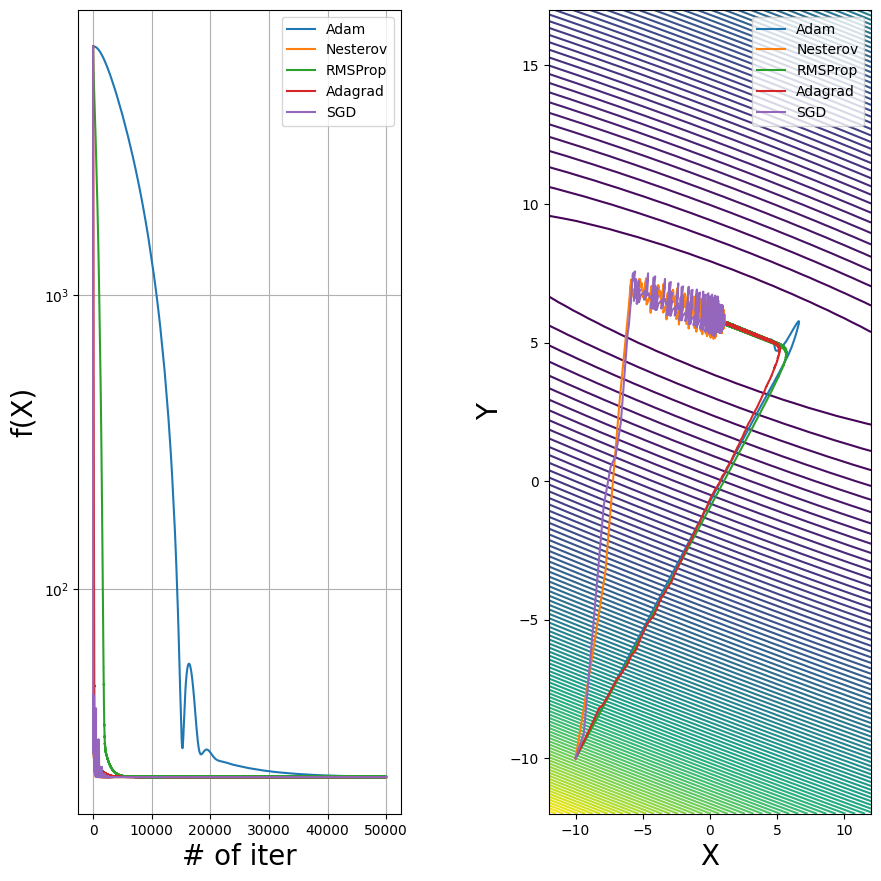

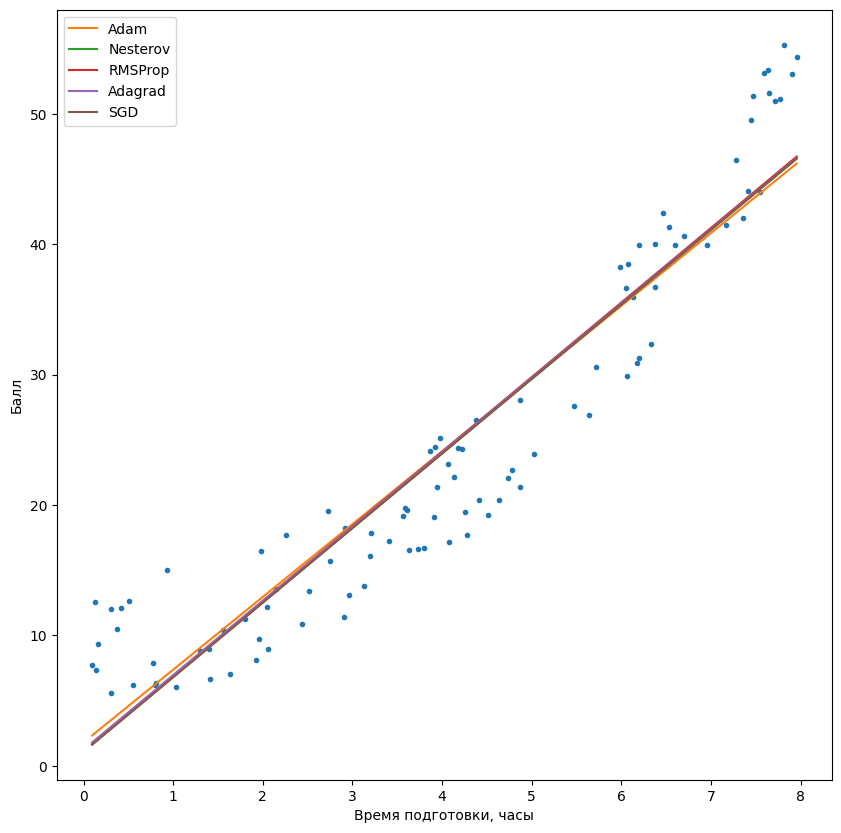

In [9]:
from funcs import squared
import time

calc_start = time.time()
visualization.linear_multiple_demo_2args(
    {
        "Adam": adam_minibatch_descent(
            f=squared(f_stud_chunk),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            decay=descent.constant_lr_decay(1e-3),
            n_epochs=1000,
            tol=1e-7,
            betta1=0.9,
            betta2=0.999,
            batch_size=2,
        ),
        "Nesterov": nesterov_minibatch_descent(
            f=squared(f_stud_chunk),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.step_decay(0.01, 0.5, 10),
            n_epochs=1000,
            tol=1e-7,
            alpha=0.35,
            batch_size=2,
        ),
        "RMSProp": rmsprop_minibatch_descent(
            f=squared(f_stud_chunk),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.constant_lr_decay(0.01),
            n_epochs=1000,
            tol=1e-7,
            alpha=0.99,
            batch_size=2,
        ),
        "Adagrad": adagrad_minibatch_descent(
            f=squared(f_stud_chunk),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.constant_lr_decay(1.0),
            n_epochs=1000,
            tol=1e-7,
            batch_size=2,
        ),
        "SGD": minibatch_descent(
            f=squared(f_stud_chunk),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.step_decay(0.01, 0.5, 10),
            n_epochs=1000,
            tol=1e-7,
            batch_size=2,
        ),
    },
    f_stud,
    *data
)
print("Elapsed: ", time.time() - calc_start, "sec.")

#### Pytorch

В PyTorch существуют абстракции для построения лосс-функций из датасетов. Так, мы можем воспользоваться `torch.util.data.DataSet` для представления нашего датасета "про студентов" в формате PyTorch.

Далее, мы можем воспользоваться `torch.util.data.DataLoader` для разбиения нашего датасета на батчи, из которых, в свою очередь, мы будем формировать Loss-функцию на каждой итерации в процессе оптимизации.

Так, мы сделаем наш `torch.optim.SGD` по-настоящему SGD. Как ни странно, в самой реализации от PyTorch у SGD нет ничего стохастического и разбиение функции на батчи - это целиком наша задача.

In [10]:
from funcs import torch_loss
from torch.utils.data import DataLoader
import dataset

y = torch.tensor(data[1], dtype=torch.float)
x = torch.tensor(data[0], dtype=torch.float)
data_set = dataset.TorchDataset(x, y)

torch_loss(x, y)(
    torch.tensor([3.247829835435748, 5.313336982957038])
)  # Eventually, data_set will be consumed by DataLoader
# that will be able to split it into batches in the same "x, y" format that can be consumed by "torch_loss" loss-function factory

tensor(23.8181)

Метод  Всего точек               Минимум в  Значение в точке минимума
0      Adam        50001   [2.171114, 5.5067616]                  23.015788
1  Nesterov        50001  [1.1028103, 5.7137704]                  22.792883
2   RMSProp        50001  [1.2412747, 5.7051787]                  22.797658
3   Adagrad        50001  [1.2263249, 5.6944733]                  22.789879
4       SGD        50001   [1.1387744, 5.706766]                  22.790976

Elapsed:  90.55747151374817 sec.


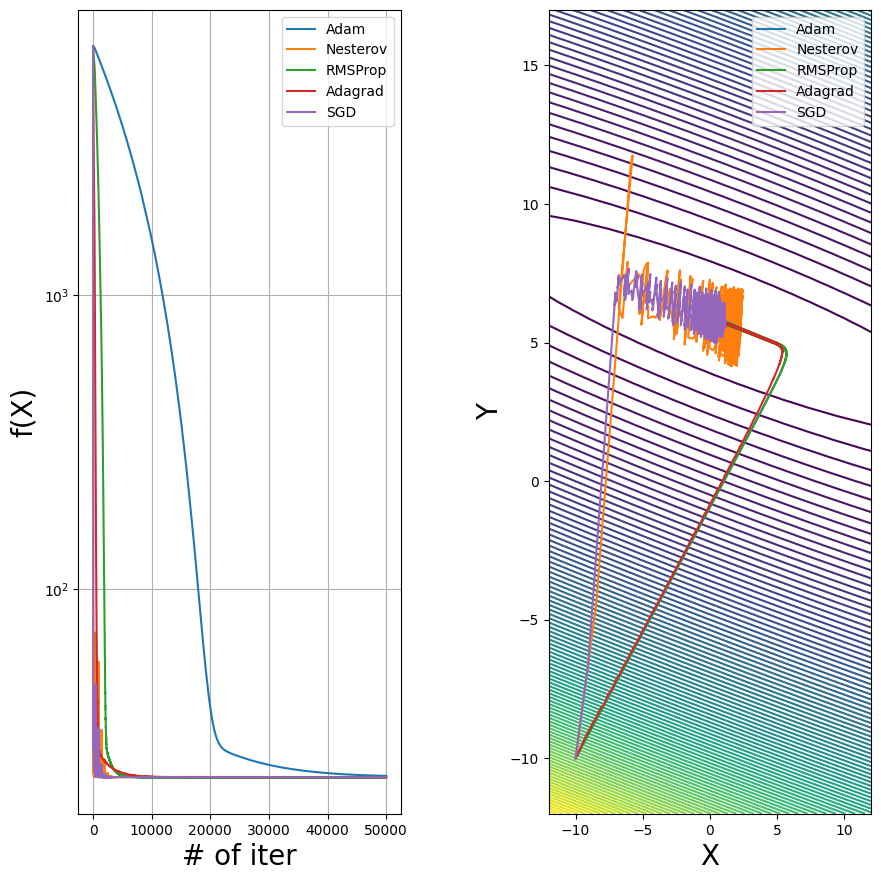

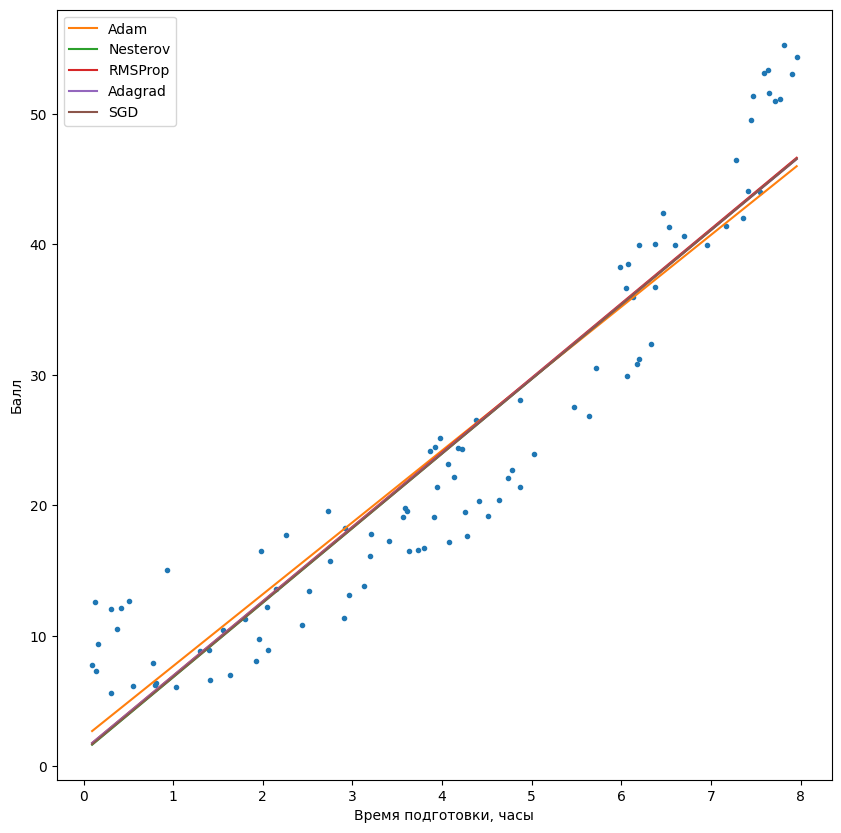

In [11]:
calc_start = time.time()
visualization.linear_multiple_demo_2args(
    {
        "Adam": descent.torch_descent_stochastic(
            torch.optim.Adam(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=1e-3,
                betas=(0.9, 0.999),
            ),
            torch_loss,
            DataLoader(dataset=data_set, batch_size=2),
            1000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "Nesterov": descent.torch_descent_stochastic(
            torch.optim.SGD(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=0.01,
                nesterov=True,
                momentum=1 - 0.35,
            ),
            torch_loss,
            DataLoader(dataset=data_set, batch_size=2),
            1000,
            torch.optim.lr_scheduler.StepLR,
            10,  # Step size
            0.5,  # Gamma
        ),
        "RMSProp": descent.torch_descent_stochastic(
            torch.optim.RMSprop(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=0.01,
                alpha=0.99,
            ),
            torch_loss,
            DataLoader(dataset=data_set, batch_size=2),
            1000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "Adagrad": descent.torch_descent_stochastic(
            torch.optim.Adagrad(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=1.0,
            ),
            torch_loss,
            DataLoader(dataset=data_set, batch_size=2),
            1000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "SGD": descent.torch_descent_stochastic(
            torch.optim.SGD(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=0.01,
            ),
            torch_loss,
            DataLoader(dataset=data_set, batch_size=2),
            1000,
            torch.optim.lr_scheduler.StepLR,
            10,  # Step size
            0.5,  # Gamma
        ),
    },
    f_stud,
    *data
)
print("Elapsed: ", time.time() - calc_start, "sec.")

Итак, судя по графикам, результаты работы алгоритмов чрезвычайно похожи. Однако, реализация PyTorch работала всего 43.563 секунды против 73.169 у нашей реализации.

Ускорение в 1.68 раза, более точное вычисление производных благодаря дуальным числам - это ещё не всё, что может дать нам PyTorch. Покажем его истинную силу:

### CUDA

Да-да, настоящая сила PyTorch сокрыта в возможности отправить вычисления прямо на нашу видеокарту. Добиться этого нетрудно, достаточно
правильно скомпилировать библиотеку, установить нужные CUDA рантаймы, иметь поддерживаемую карту, а так же проинициализировать всё правильно:

In [12]:
import torch

torch.cuda.is_available()

True

Видим, что `cuda.is_available() == True`, а значит, мы можем двигаться дальше. Осталось просто добавить нашим тензорам параметр `device=cuda` и "дело в шляпе":

In [13]:
cuda = torch.device("cuda:0")
torch.cuda.get_device_name(cuda)

'NVIDIA GeForce RTX 3080'

In [14]:
x_cuda = x.to(cuda)
y_cuda = y.to(cuda)
data_set_cuda = dataset.TorchDataset(x_cuda, y_cuda)

torch_loss(x_cuda, y_cuda)(
    torch.tensor([3.247829835435748, 5.313336982957038], device=cuda)
)

tensor(23.8181, device='cuda:0')

Метод  Всего точек               Минимум в  Значение в точке минимума
0      Adam        10001    [1.2238607, 5.68875]                  22.789031
1  Nesterov        10001   [1.2238156, 5.688759]                  22.789031
2   RMSProp        10001  [1.2188601, 5.6837516]                  22.789814
3   Adagrad        10001  [1.2455146, 5.6845646]                  22.789150
4       SGD        10001   [1.1617899, 5.700387]                  22.790000

Elapsed:  79.38866853713989 sec.


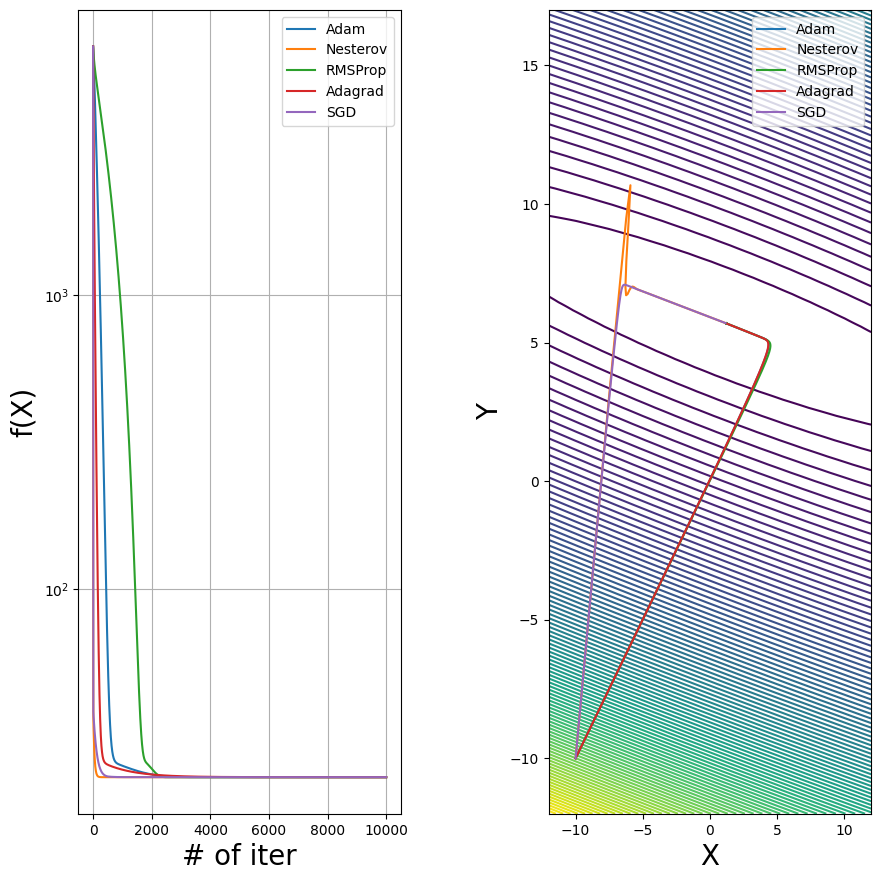

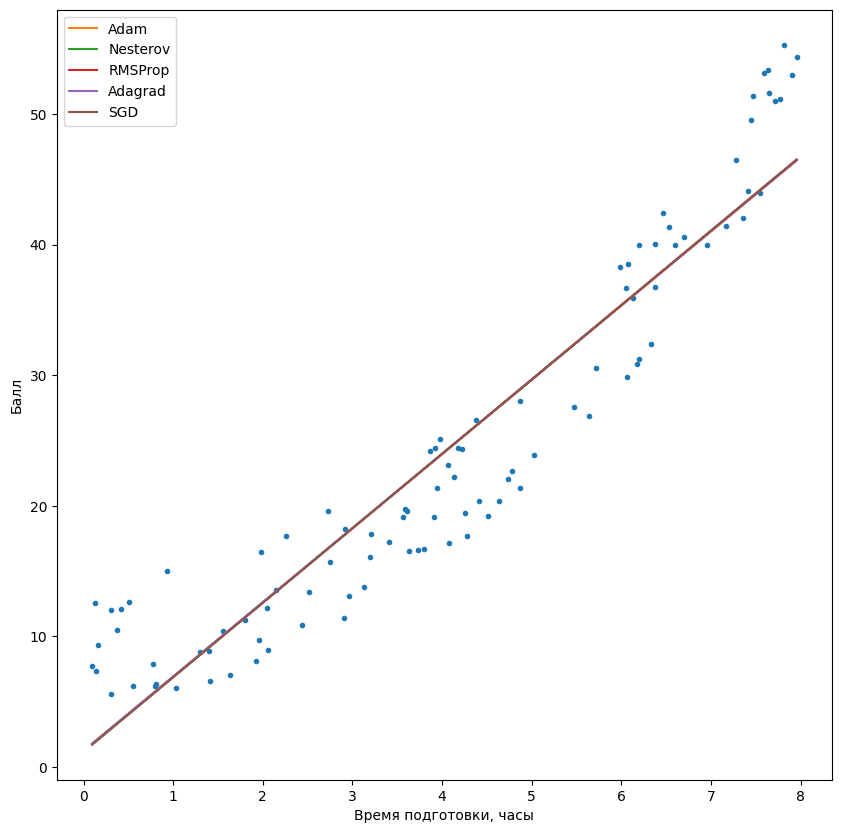

In [15]:
import time

calc_start = time.time()
visualization.linear_multiple_demo_2args(
    {
        "Adam": descent.torch_descent_stochastic(
            torch.optim.Adam(
                [torch.tensor([-10.0, -10.0], requires_grad=True, device=cuda)],
                lr=5e-2,
                betas=(0.9, 0.999),
            ),
            torch_loss,
            DataLoader(dataset=data_set_cuda, batch_size=100),
            10000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "Nesterov": descent.torch_descent_stochastic(
            torch.optim.SGD(
                [torch.tensor([-10.0, -10.0], requires_grad=True, device=cuda)],
                lr=0.01,
                nesterov=True,
                momentum=1 - 0.35,
            ),
            torch_loss,
            DataLoader(dataset=data_set_cuda, batch_size=100),
            10000,
            torch.optim.lr_scheduler.StepLR,
            500,  # Step size
            0.5,  # Gamma
        ),
        "RMSProp": descent.torch_descent_stochastic(
            torch.optim.RMSprop(
                [torch.tensor([-10.0, -10.0], requires_grad=True, device=cuda)],
                lr=0.01,
                alpha=0.99,
            ),
            torch_loss,
            DataLoader(dataset=data_set_cuda, batch_size=100),
            10000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "Adagrad": descent.torch_descent_stochastic(
            torch.optim.Adagrad(
                [torch.tensor([-10.0, -10.0], requires_grad=True, device=cuda)],
                lr=1.0,
            ),
            torch_loss,
            DataLoader(dataset=data_set_cuda, batch_size=100),
            10000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "SGD": descent.torch_descent_stochastic(
            torch.optim.SGD(
                [torch.tensor([-10.0, -10.0], requires_grad=True, device=cuda)],
                lr=0.01,
            ),
            torch_loss,
            DataLoader(dataset=data_set_cuda, batch_size=100),
            10000,
            torch.optim.lr_scheduler.StepLR,
            500,  # Step size
            0.5,  # Gamma
        ),
    },
    f_stud,
    *data
)
print("Elapsed: ", time.time() - calc_start, "sec.")

Итак, на предыдущих демонстрациях мы делали epoch*(dataset_size/batch_size)=1000*(100/2)=50000 итераций стохастического спуска.

Теперь мы смогли перенести вычисления на GPU, благодаря чему мы можем значительно снизить стоимость увеличения batch_size.
То есть теперь мы можем делать не стохастический спуск одновременно по всему датасету, что позволяет значительно повысить точность спуска и, следовательно, увеличить learing_rate и уменьшить число epoch
А так же, мы можем бесплатно увеличивать размер датасета, что не повлияет ни на скорость спуска, так как итерации вычисления градиента по всему батчу распараллелены на CUDA ядрах.
Это может продолжаться пока у нас хватает вычислителей и видеопамяти для таких манипуляций. То есть теперь batch_size выгодно выставить именно такого размера, какой видеокарта может эффективно распараллелить (в нашем случае датасет имеет размер всего 100, а значит batch_size будет равен размеру датасета).


Увеличим epoch в 50 раз, получим 50000*(100/100)=50000 итераций НЕСТОХАСТИЧЕСКОГО спуска. Точность гораздо выше, а время вычислений всего 5 минут (в 5 раз выше однопоточных вычислений на процессоре, при том, что мы увеличили стоимость каждого шага в 50 раз за счёт увеличения batch_size).

Теперь воспользуемся преимуществом в точности спуска и уменьшим число epoch в 5 раз (теперь имеем 10000*(100/100)=10000 итераций). Все алгоритмы сошлись идеально в одной точке минимума точнее, чем за 50000 итераций на процессоре (так как спуск более не стохастический всё же), но при этом время вычисления вообще не изменилось: имеем всё те же 60 секунд, что и раньше.

### Вывод

В ходе выполнения задания было проведено сравнение собственной реализации методов оптимизации на Python и реализации этих же методов в библиотеке PyTorch. Были рассмотрены следующие методы: SGD, Nesterov, RMSprop, Adagrad и Adam.

Согласно полученным результатам, обе реализации показывают схожие результаты в плане сходимости алгоритмов. Однако, реализация PyTorch показала значительное преимущество в скорости работы - она была быстрее на 68%, что является важным фактором при работе с большими объемами данных.

Более того, PyTorch предоставляет возможность использования вычислительных ресурсов графического процессора (GPU), что позволяет еще больше ускорить процесс оптимизации. Это особенно актуально при работе с большими объемами данных и когда возможно использование больших размеров батчей.

Так, при использовании GPU, время вычислений сократилось до 5 минут при увеличении количества эпох в 50 раз, что в 5 раз быстрее, чем однопоточные вычисления на процессоре. При этом, точность спуска значительно возросла благодаря использованию нестохастического спуска.

Вывод: использование готовых реализаций методов оптимизации из библиотеки PyTorch позволяет значительно ускорить процесс оптимизации, увеличить его точность и эффективно использовать ресурсы графического процессора. Это делает PyTorch предпочтительным выбором для работы с большими объемами данных и сложными моделями.


## Задание 2. Исследование методов оптимизации SciPy


### Сравнение с прошлой работой

22
22


Метод  Всего точек                                 Минимум в   
0         bfgs           93  [0.9999954918500032, 0.9999909775963927]  \
1       dogleg           39  [0.9999999999984261, 0.9999999999958811]   
2       newton           39  [1.0000000003831997, 1.0000000007588794]   
3  dogleg ours           16                                [1.0, 1.0]   
4    bfgs ours           22  [0.9999999301921173, 0.9999998570349513]   
5  l-bfgs ours           61  [0.9999999997973403, 0.9999999995946247]   

   Значение в точке минимума  Время работы      Память  
0               2.032717e-11      0.020023  415.680990  
1               9.680444e-23      0.089252  415.730469  
2               1.524970e-19      0.116379  415.730469  
3               0.000000e+00      0.002000  415.730469  
4               5.994914e-15      0.001999  415.730469  
5               4.107125e-20      0.009592  415.733073

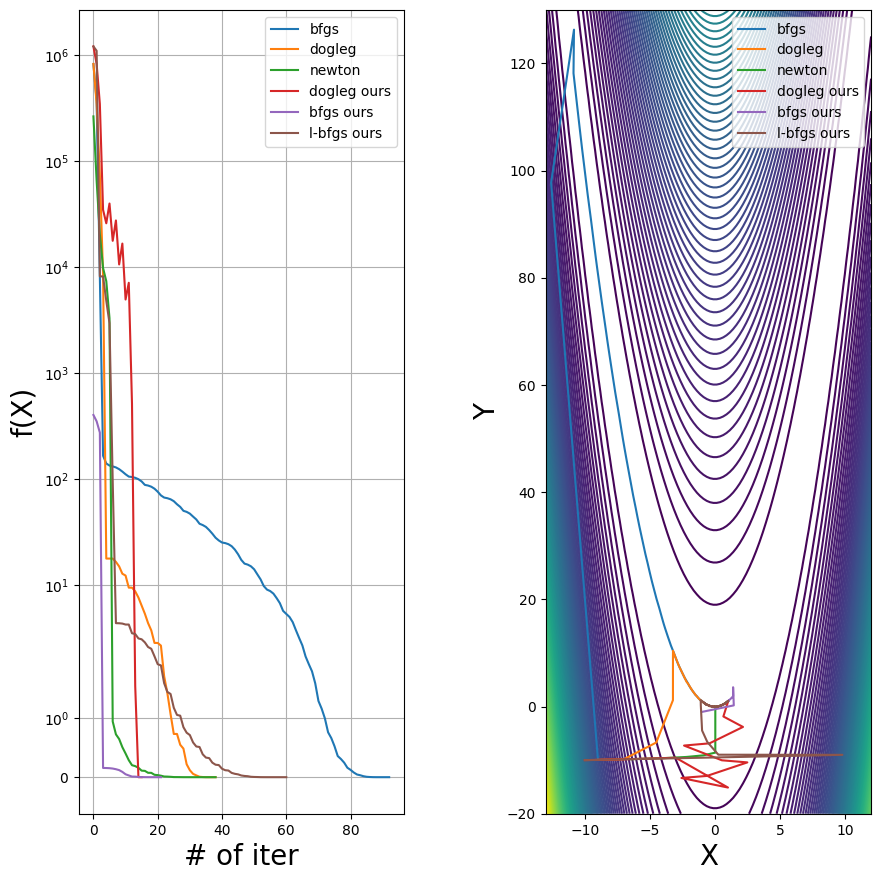

In [29]:
import descent
import bfgs

reload(descent)
reload(visualization)

visualization.visualize_multiple_descent_2args_wh_time(
    {
        "bfgs": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            method="bfgs",
            tol=1e-6,
            jac="2-point",
        ),
        "dogleg": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            method="dogleg",
            tol=1e-6,
            jac=descent.get_jac(f_rosenbrock),
            hess=descent.get_hess(f_rosenbrock),
        ),
        "newton": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            method="newton-cg",
            tol=1e-6,
            jac=descent.get_jac(f_rosenbrock),
        ),
        "dogleg ours": lambda: descent.powell_dog_leg(
            x0=np.array([-10.0, -10.0]),
            rsl=f_rosenbrock_chunk(),
            grad=descent.numeric_gradient,
        ),
        "bfgs ours": lambda: bfgs.bfgs(
            f_rosenbrock,
            descent.numeric_gradient,
            x_0=np.array((-1.0, -1.0)),
            epochs=1000,
        ),
        "l-bfgs ours": lambda: bfgs.l_bfgs(
            f_rosenbrock,
            descent.numeric_gradient,
            x_0=np.array((-10.0, -10.0)),
            epochs=1000,
        ),
    },
    f_rosenbrock,
    visualization_area=((-13, 12), (-20, 130)),
)

6
6


Метод  Всего точек                                 Минимум в   
0         bfgs           10  [1.2238579675343364, 5.6887503750872535]  \
1       dogleg            5    [1.223858107502977, 5.688750421250443]   
2  dogleg ours            7   [1.2238581051870203, 5.688750421713798]   
3  l-bfgs ours            8   [1.2238581024062354, 5.688750422245381]   
4    bfgs ours            6   [1.2238581045519576, 5.688750384737323]   

   Значение в точке минимума  Время работы       Память  
0                  22.789031      0.593535  2794.844238  
1                  22.789031      5.884899  2794.843750  
2                  22.789031      0.191009  2794.843750  
3                  22.789031      4.540605  2794.843750  
4                  22.789031      0.742627  2794.843750

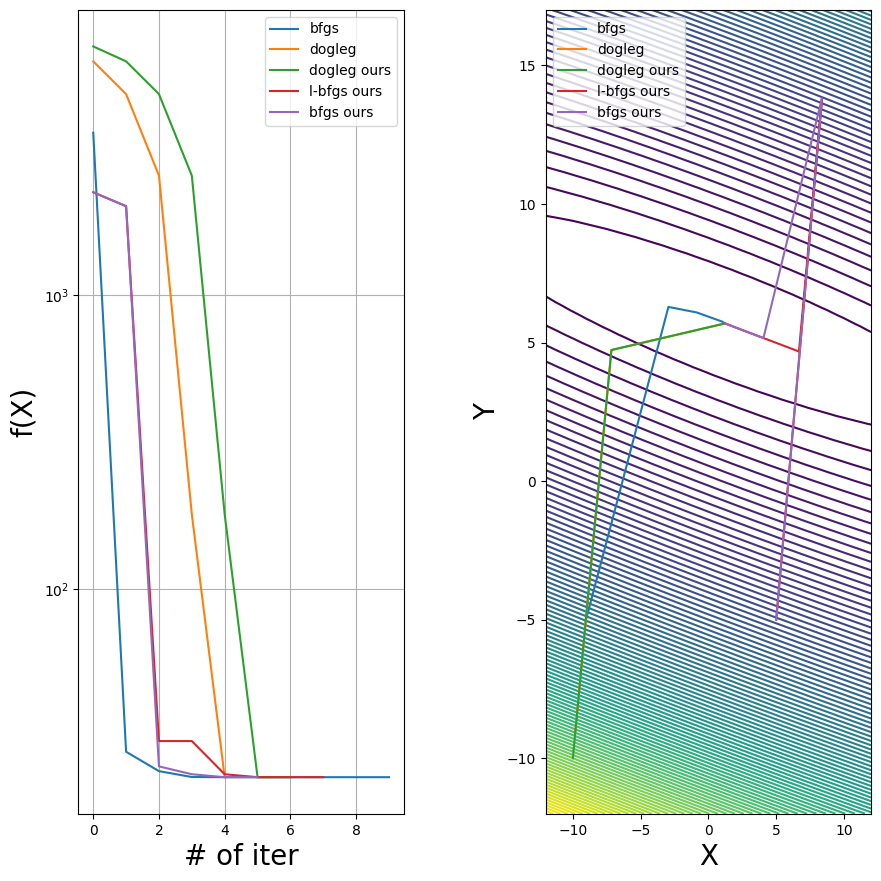

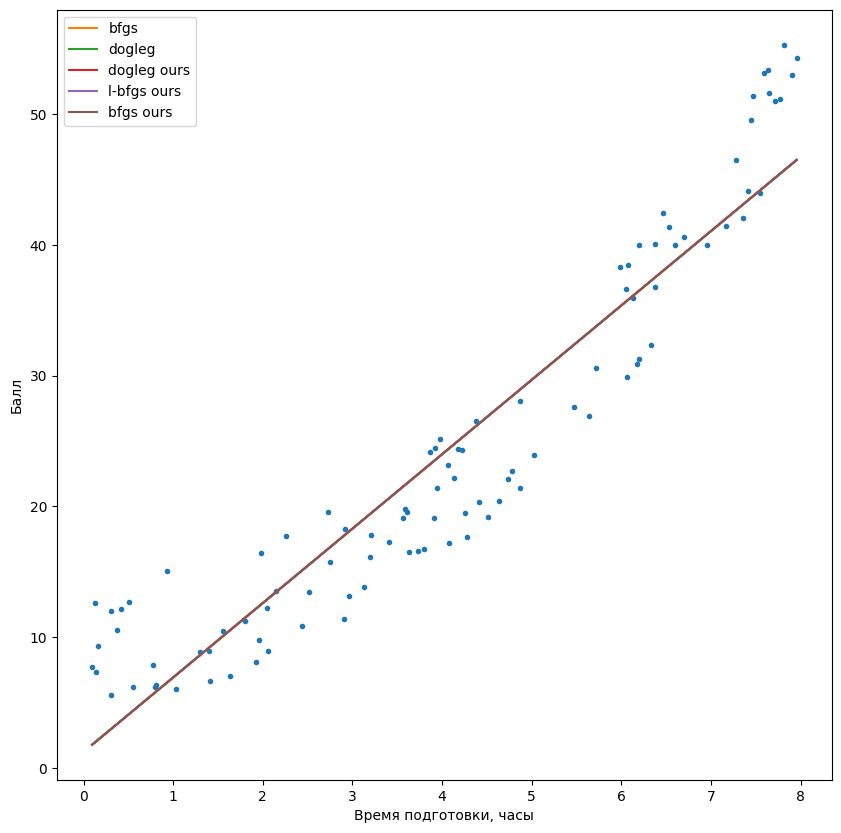

In [17]:
import descent
import bfgs

reload(descent)
reload(bfgs)
reload(visualization)

f, f_chunk = dataset.get_linear_loss_func(*data)
visualization.linear_multiple_demo_2args_wh_time(
    {
        "bfgs": lambda: descent.scipy_descent(
            f, np.array([-10.0, -10.0]), method="bfgs", tol=1e-6, jac="2-point"
        ),
        "dogleg": lambda: descent.scipy_descent(
            f,
            np.array([-10.0, -10.0]),
            method="dogleg",
            tol=1e-6,
            jac=descent.get_jac(f),
            hess=descent.get_hess(f),
        ),
        "dogleg ours": lambda: descent.powell_dog_leg(
            x0=np.array([-10.0, -10.0]), rsl=f_chunk, grad=descent.numeric_gradient
        ),
        "l-bfgs ours": lambda: bfgs.l_bfgs(
            f, descent.numeric_gradient, x_0=np.array((5.0, -5.0)), epochs=10
        ),
        "bfgs ours": lambda: bfgs.bfgs(
            f, descent.numeric_gradient, x_0=np.array((5.0, -5.0)), epochs=10
        ),
    },
    f,
    *data
)

// :NOTE: комментарий к графикам

#### scipy.optimize.minimize

In [ ]:
# todo

//todo

#### scipy.optimize.least_squares

In [ ]:
# todo

//todo

### Вычисление градиента с помощью PyTorch, сравнение

Метод  Всего точек                                 Минимум в   
0    bfgs           93  [0.9999954918500032, 0.9999909775963927]  \
1  dogleg           39  [0.9999999999984261, 0.9999999999958811]   
2  newton           39  [1.0000000003831997, 1.0000000007588794]   

   Значение в точке минимума  Время работы      Память  
0               2.032717e-11      0.018574  546.751302  
1               9.680444e-23      0.084547  546.757812  
2               1.524970e-19      0.119048  546.757812

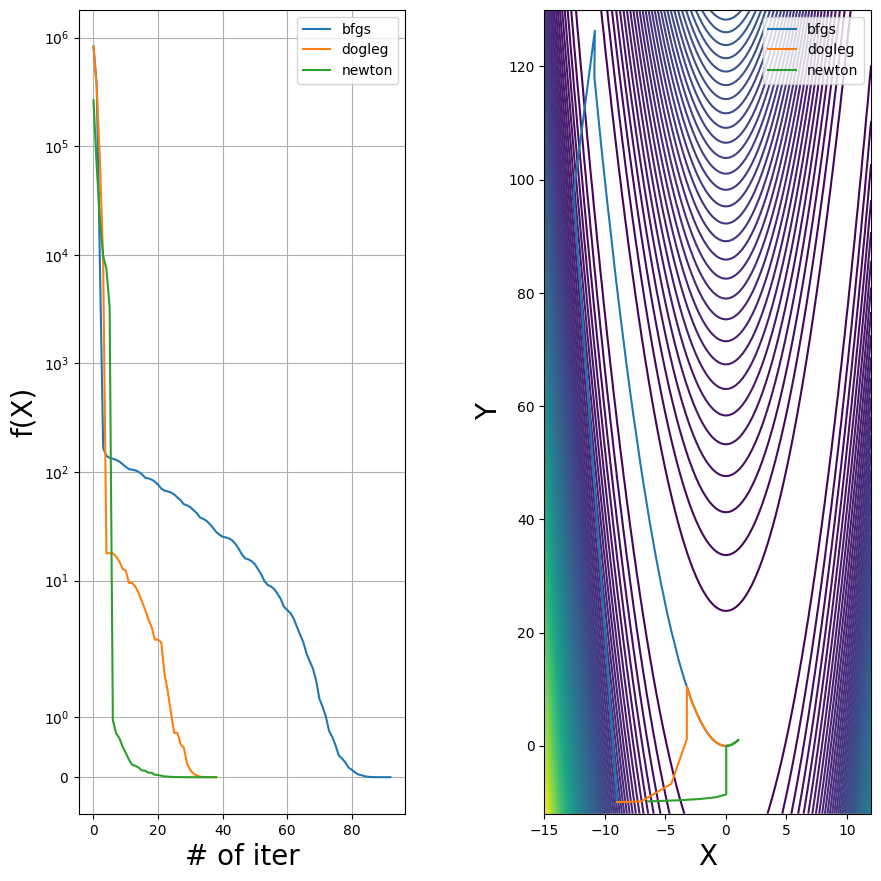

In [30]:
import descent

reload(descent)
reload(visualization)

visualization.visualize_multiple_descent_2args_wh_time(
    {
        "bfgs": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            method="bfgs",
            tol=1e-6,
            jac="2-point",
        ),
        "dogleg": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            method="dogleg",
            tol=1e-6,
            jac=descent.get_jac(f_rosenbrock),
            hess=descent.get_hess(f_rosenbrock),
        ),
        "newton": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            method="newton-cg",
            tol=1e-6,
            jac=descent.get_jac(f_rosenbrock),
        ),
    },
    f_rosenbrock,
    visualization_area=((-15, 12),(-12, 130)),
)

// :NOTE: pytorch autograd impl
// :NOTE: короткй комментарий к графикам

#### scipy.optimize.minimize

In [ ]:
# todo

// todo

#### scipy.optimize.least_squares

In [ ]:
# todo

// todo

### Изменение параметров и границ, сравнение

// :NOTE: текст, что происходит, что делаем

Метод  Всего точек                                 Минимум в   
0  bfgs-1           23   [1.000004561750412, 1.0000093537854424]  \
1  bfgs-2           29  [0.9999905116037315, 0.9999802799070968]   
2  bfgs-3           29  [0.9999905116037315, 0.9999802799070968]   

   Значение в точке минимума  Время работы       Память  
0               2.611171e-11      0.005380  2793.148438  
1               1.452926e-10      0.005212  2793.148438  
2               1.452926e-10      0.005023  2793.148438

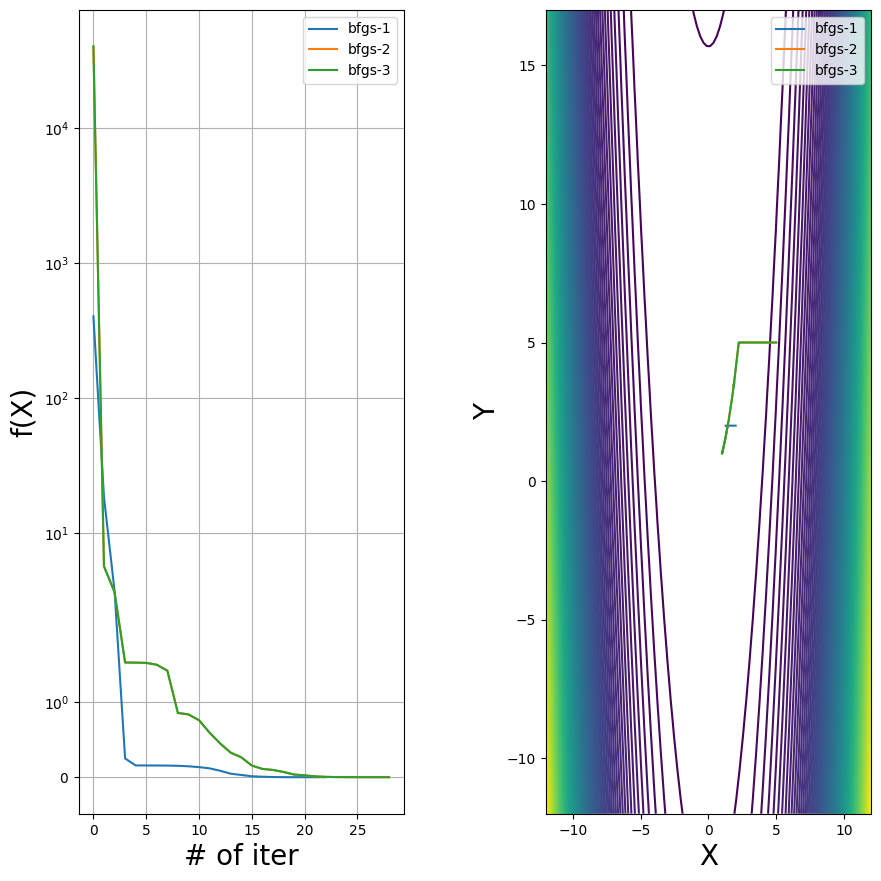

In [19]:
import scipy
from funcs import f_rosenbrock

bounds1 = scipy.optimize.Bounds(-2, 2)
bounds2 = scipy.optimize.Bounds(-5, 5)
bounds3 = scipy.optimize.Bounds(-10, 10)
visualization.visualize_multiple_descent_2args_wh_time(
    {
        "bfgs-1": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            bounds=bounds1,
            method="l-bfgs-b",
            tol=1e-6,
            jac="2-point",
        ),
        "bfgs-2": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            bounds=bounds2,
            method="l-bfgs-b",
            tol=1e-6,
            jac="2-point",
        ),
        "bfgs-3": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            bounds=bounds2,
            method="l-bfgs-b",
            tol=1e-6,
            jac="2-point",
        ),
    },
    f_rosenbrock,
)

Метод  Всего точек                                 Минимум в   
0  TNC-1           28  [1.3608782428144717, 1.8379147321047464]  \
1  TNC-2           25   [0.9998806798506402, 0.999762975327088]   
2  TNC-3           28  [1.3797452035733737, 1.8922064914528376]   

   Значение в точке минимума  Время работы  Память  
0               1.500433e-01      0.017047  2800.0  
1               1.449374e-08      0.010513  2800.0  
2               1.574092e-01      0.010532  2800.0

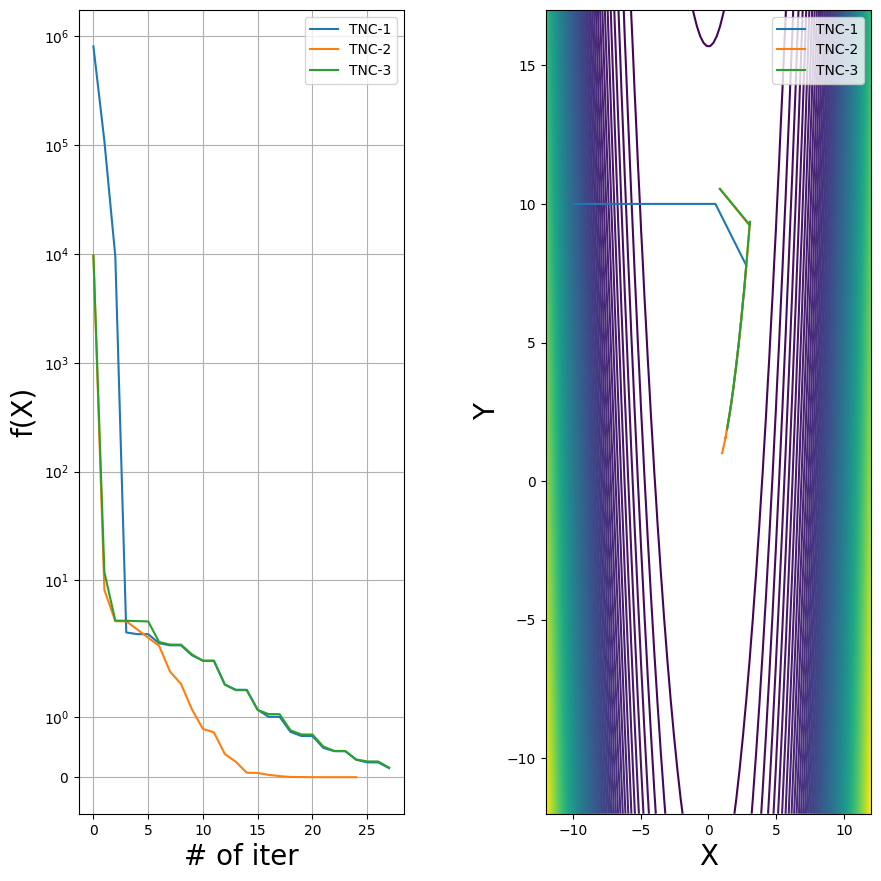

In [20]:
import scipy
from funcs import f_rosenbrock

bounds3 = scipy.optimize.Bounds(-200, 200)
bounds2 = scipy.optimize.Bounds(-50, 50)
bounds1 = scipy.optimize.Bounds(-10, 10)
x0 = np.array([-10.0, 10.0])
visualization.visualize_multiple_descent_2args_wh_time(
    {
        "TNC-1": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            bounds=bounds1,
            method="tnc",
            tol=1e-6,
            jac="2-point",
        ),
        "TNC-2": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            bounds=bounds2,
            method="tnc",
            tol=1e-6,
            jac="2-point",
        ),
        "TNC-3": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            bounds=bounds3,
            method="tnc",
            tol=1e-6,
            jac="2-point",
        ),
    },
    f_rosenbrock,
)

Метод  Всего точек   Минимум в  Значение в точке минимума   
0  trust-constr-bounds1            1  [0.0, 0.0]                        1.0  \
1  trust-constr-bounds2            1  [0.0, 0.0]                        1.0   
2  trust-constr-bounds3            1  [0.0, 0.0]                        1.0   

   Время работы       Память  
0      0.004025  2807.019531  
1      0.002999  2807.019531  
2      0.001011  2807.019531

C:\Users\Тимофей\Desktop\Учёба\Сем 4\МетОпт\meth_opt_lab4\visualization.py:79: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.tight_layout(pad=5.0)


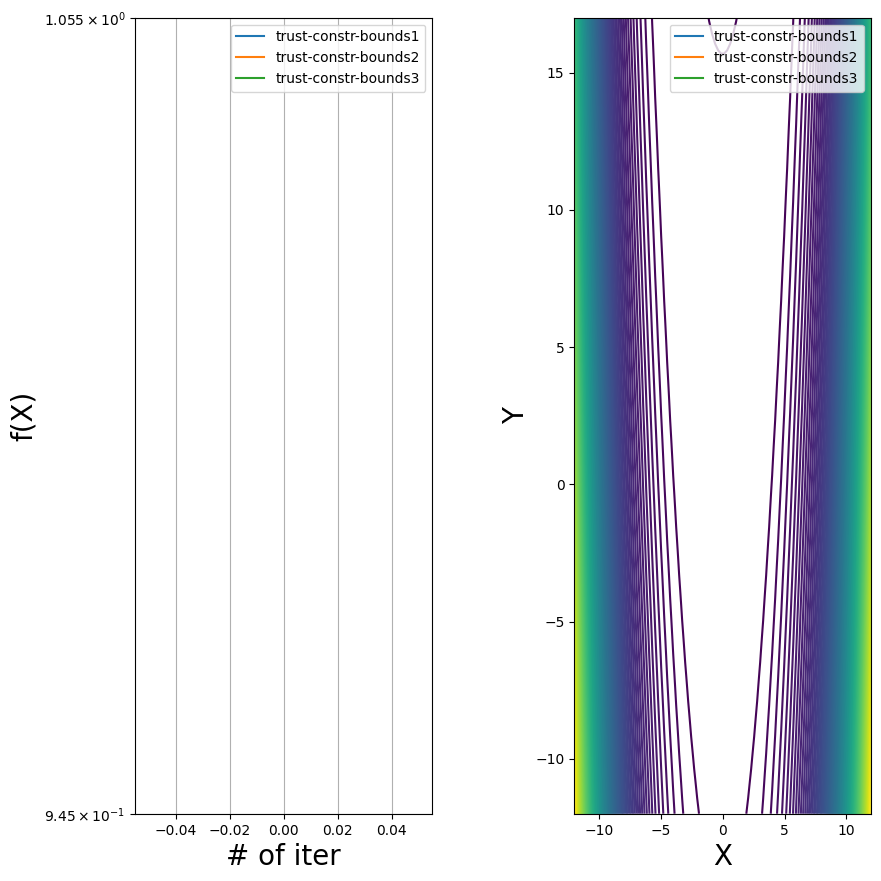

In [21]:
import numpy as np
from scipy.optimize import Bounds
from funcs import f_rosenbrock
import descent
import visualization

reload(descent)

bounds1 = Bounds([-5, -5], [5, 5])  # границы от -5 до 5 для каждого параметра
bounds2 = Bounds([-10, -10], [10, 10])  # границы от -10 до 10 для каждого параметра
bounds3 = Bounds([-20, -20], [20, 20])  # границы от -20 до 20 для каждого параметра
x0 = np.array([0.0, 0.0])

visualization.visualize_multiple_descent_2args_wh_time(
    {
        "trust-constr-bounds1": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            bounds=bounds1,
            method="trust-constr",
            tol=1e-6,
            jac="2-point",
        ),
        "trust-constr-bounds2": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            bounds=bounds2,
            method="trust-constr",
            tol=1e-6,
            jac="2-point",
        ),
        "trust-constr-bounds3": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            # bounds=bounds3,
            method="trust-constr",
            tol=1e-9,
            jac="2-point",
        ),
    },
    f_rosenbrock,
)


Метод  Всего точек                                Минимум в   
0  newton            2  [5.716904209461063, 1.0657253169920295]  \

   Значение в точке минимума  Время работы       Память  
0                 348.012816      1.382579  2813.878906

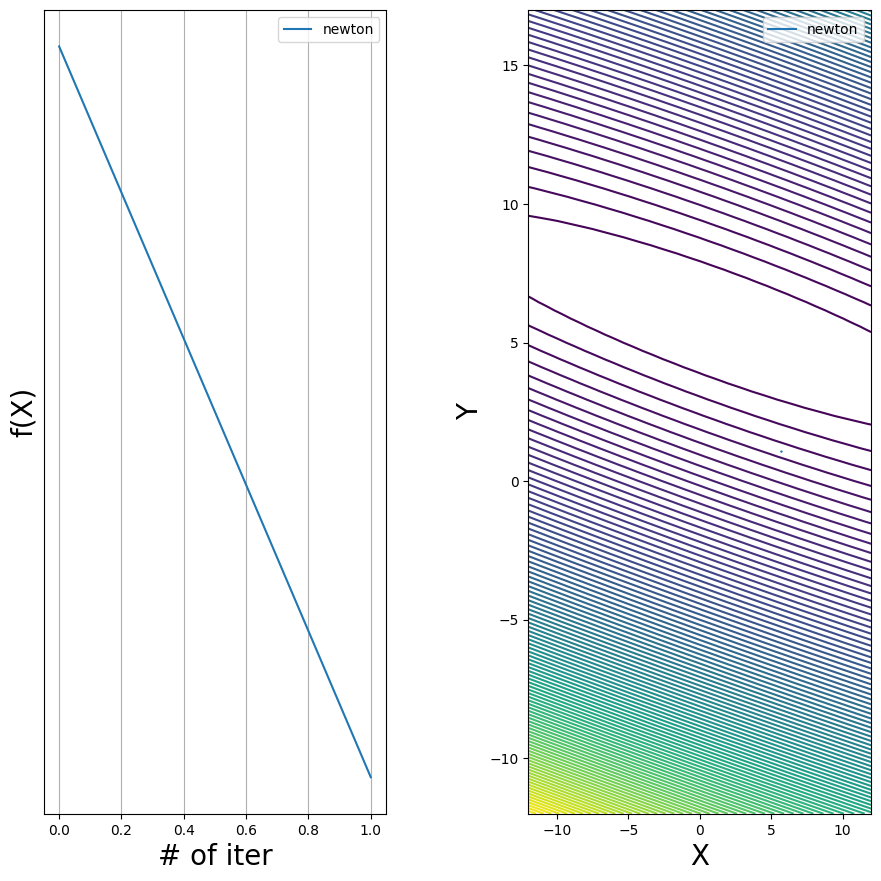

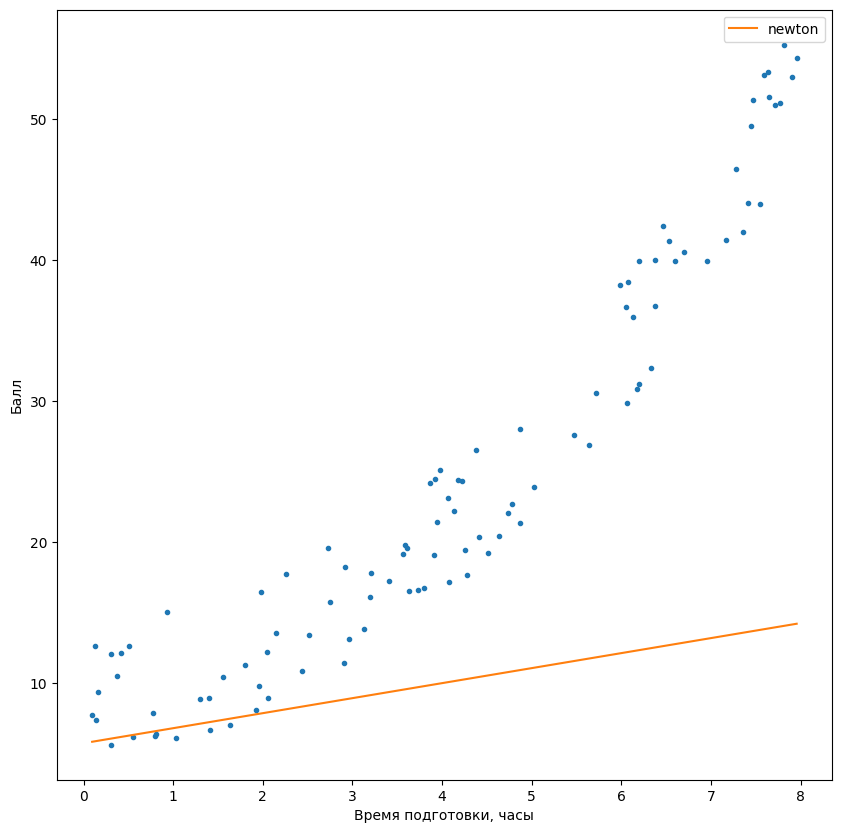

In [22]:
reload(dataset)
from dataset import get_data, torch_linear_loss_func

data = get_data()
X, Y = data
f, _ = dataset.get_linear_loss_func(*data)

loss_and_grad_func = torch_linear_loss_func(X, Y)

visualization.linear_multiple_demo_2args_wh_time(
    {
        "newton": lambda: descent.scipy_descent(
            loss_and_grad_func,
            np.array([0.0, 0.0]),
            method="newton-cg",
            tol=1e-9,
            jac=True,
        )
    },

    f,
    *data
)

#### scipy.optimize.minimize

#### scipy.optimize.least_squares

### Вывод

// Вывод

# Бонусное задание

## Задание 1. Исследование использования ограничений SciPy при работе с scipy.optimize.minimize

### scipy.optimize.LinearConstraint

В этом разделе мы учимся использовать инструментарий SciPy для оптимизации функции с ограничениями. Для рассмотрения возьмём уже полюбившуюся нам функцию Розенброка. Она имеет минимум в точке $f(1, 1) = 0$

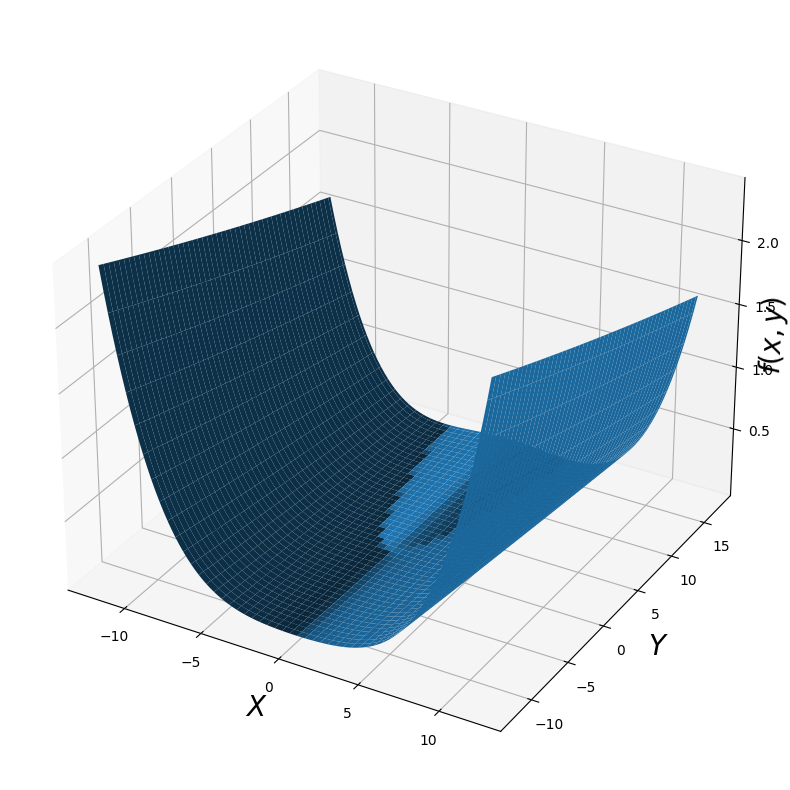

In [23]:
from funcs import f_rosenbrock
from visualization import visualize_2arg

visualize_2arg(f_rosenbrock)

Тогда давайте рассмотрим следующие области:

1. $\forall x, y$
2. $-100 < x, y < 100$
3. $0 < x, y < 2$
4. $-10 < x + y < 10$
5. $-100 < 100 x - 100 y < 500$

Метод  Всего точек                                     Минимум в   
0  lin-cons-1           23      [0.9997224001937951, 0.9994347943859752]  \
1  lin-cons-2           23      [0.9997222797251173, 0.9994345339760707]   
2  lin-cons-3           20      [0.9997754091333942, 0.9995550008827063]   
3  lin-cons-4            3  [0.00961352877473158, -0.009613528774723608]   
4  lin-cons-5            2      [0.9999992474913588, 0.9999992474913606]   

   Значение в точке минимума  Время работы       Память  
0               8.722847e-08      0.003999  2798.855469  
1               8.733481e-08      0.008517  2798.867188  
2               5.214854e-08      0.005510  2798.867188  
3               9.902859e-01      0.001000  2798.867188  
4               5.719311e-11      0.000000  2798.867188

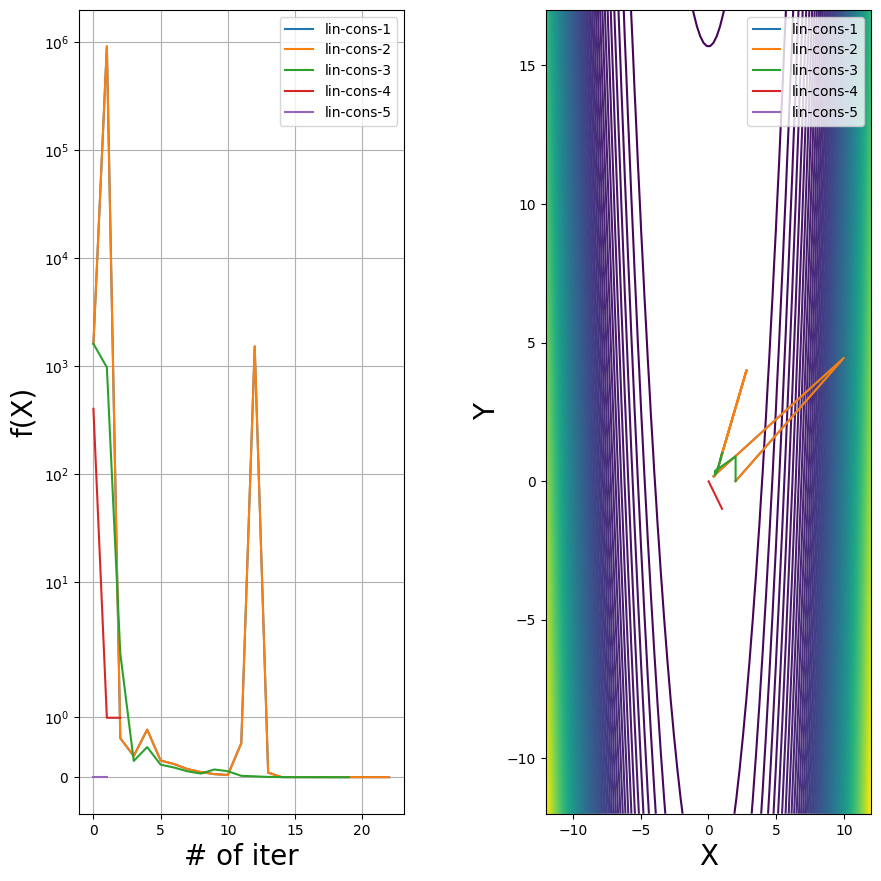

In [24]:
import numpy as np
from scipy.optimize import LinearConstraint
from funcs import f_rosenbrock
import descent
import visualization

reload(descent)


lin_cons2 = LinearConstraint([[1, 0], [0, 1,]], [-100, -100], [100, 100])
lin_cons3 = LinearConstraint([[1, 0], [0, 1,]], [-10, -10], [2, 2])
lin_cons4 = LinearConstraint([[1, 1], [0, 0,]], [-10, -10], [0, 0])
lin_cons5 = LinearConstraint([[100, -100], [0, 0,]], [-100, -100], [0, 0])

x0 = np.array([0.0, 0.0])


visualization.visualize_multiple_descent_2args_wh_time(
    {
        "lin-cons-1": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            #constraints=lin_cons1,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "lin-cons-2": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons2,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "lin-cons-3": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons3,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "lin-cons-4": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons4,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "lin-cons-5": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons5,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        )
    },
    f_rosenbrock,
)


Как можно видеть, при правильном выборе ограничений, можно в разы сократить число необходимых шагов для достижения экстремума. И это даже при достаточно скудном интсрументарии, ведь задавая линейные ограничения мы можем оперировать только линейными комбинациями координат. Также отметим, что в данном примере минимум лежал внутри рассматриваемых областей. Посмотрим, как ведёт себя метод при задаче ограничений, когда минимум находится на границе (или вне)

Метод  Всего точек                                 Минимум в   
0  lin-cons-2            1                                [0.0, 0.0]  \
1  lin-cons-3           13                 [10.0, 99.99999930735483]   
2  lin-cons-4           15  [1.0000650570306844, 1.0001294359561168]   
3  lin-cons-5           23  [0.9997762503130149, 0.9994944155695006]   

   Значение в точке минимума  Время работы       Память  
0               1.000000e+00      0.001001  2801.835938  
1               8.100000e+01      0.003561  2801.835938  
2               4.278976e-09      0.003502  2801.835938  
3               3.880331e-07      0.006002  2801.835938

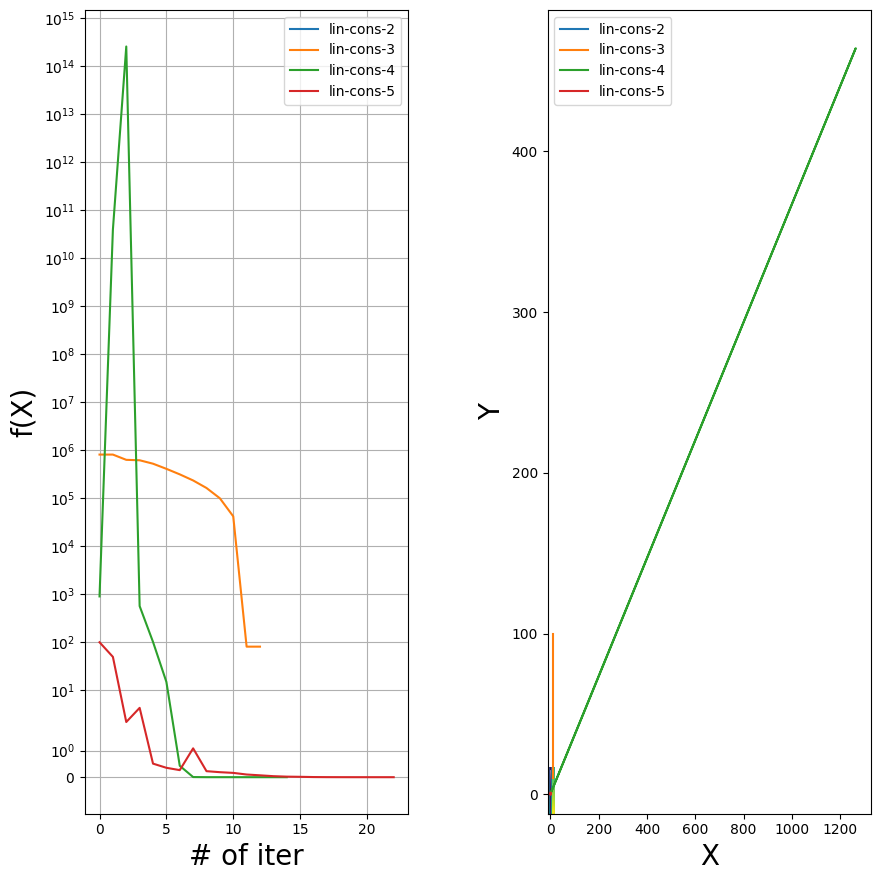

In [25]:
import numpy as np
from scipy.optimize import LinearConstraint
from funcs import f_rosenbrock
import descent
import visualization

reload(descent)


lin_cons2 = LinearConstraint([[1, 0], [0, 1,]], [-100, -100], [0, 0])
lin_cons3 = LinearConstraint([[1, 0], [0, 1,]], [10, 10], [np.inf, np.inf])
lin_cons4 = LinearConstraint([[1, 0], [0, 1,]], [1, 1], [np.inf, np.inf])
lin_cons5 = LinearConstraint([[1, 0], [0, 1,]], [-np.inf, -np.inf], [1, 1])


x0 = np.array([0.0, 0.0])


visualization.visualize_multiple_descent_2args_wh_time(
    {
        "lin-cons-2": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons2,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "lin-cons-3": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons3,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "lin-cons-4": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons4,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "lin-cons-5": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons5,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        )
    },
    f_rosenbrock,
)


Мы пытаемся прийти к минимуму, но останавливаемся на границе области, в приницпе, этого и следовало ожидать.

### scipy.optimize.NonlinearConstraint

Теперь мы можем перейти к использованию нелинейных ограничений. Теперь мы не ограничены линейными соотношениями, и можем задавать любую функцию от аргументов, и границы на неё. Посмотрим на набор из цилиндров с вырезанным центром:

1. Окружности с центром в $(0, 0)$ и радиусами $0.001 < R^2 < \infty$
2. $0.0001 < R^2 < \infty$
3. $0 < R^2 < 2$

Метод  Всего точек                                 Минимум в   
0  non-lin-cons-1           93   [1.0001941371755623, 1.000324127151334]  \
1  non-lin-cons-2           33  [1.0000829018734654, 1.0001699395523673]   
2  non-lin-cons-3           21   [0.9997284829202617, 0.999444442898433]   

   Значение в точке минимума  Время работы       Память  
0               4.496592e-07      0.028880  2793.820312  
1               8.577529e-09      0.010054  2793.820312  
2               8.958912e-08      0.006998  2793.820312

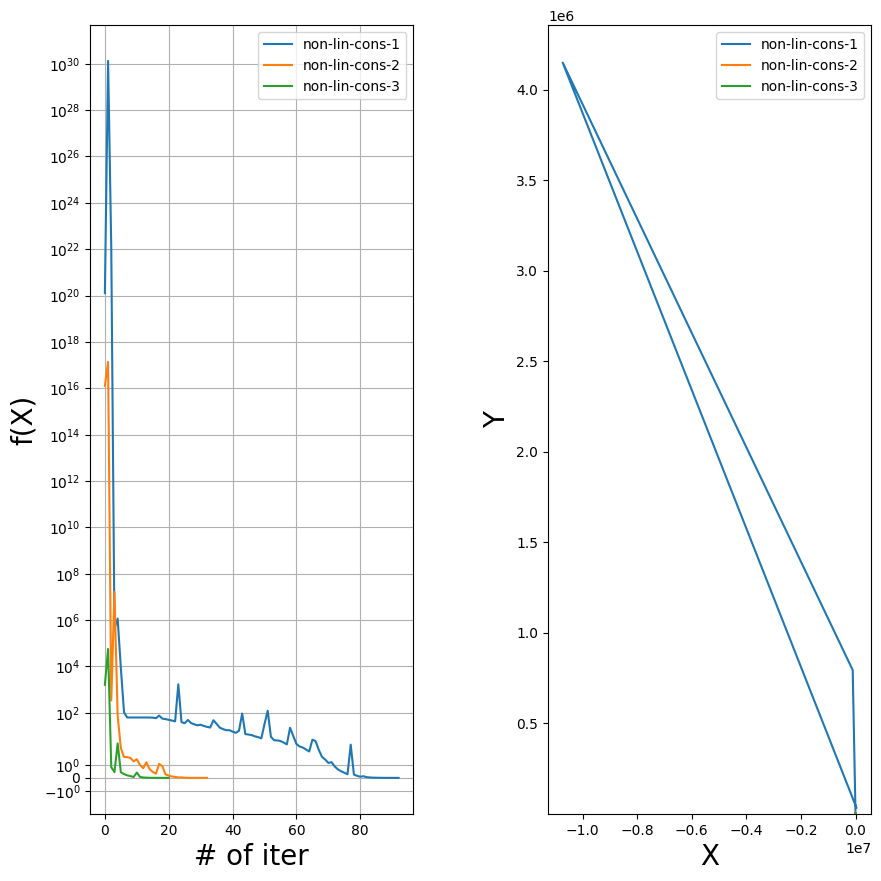

In [26]:
import numpy as np
from scipy.optimize import NonlinearConstraint
from funcs import f_rosenbrock
import descent
import visualization

reload(descent)


non_lin1 = NonlinearConstraint(lambda x: x[0] ** 2 + x[1] ** 2, 0.001, np.inf)
non_lin2 = NonlinearConstraint(lambda x: x[0] ** 2 + x[1] ** 2, 0.0001, np.inf)
non_lin3 = NonlinearConstraint(lambda x: x[0] ** 2 + x[1] ** 2, 0, 2)


x0 = np.array([0.0, 0.0])


visualization.visualize_multiple_descent_2args_wh_time(
    {
        "non-lin-cons-1": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=non_lin1,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "non-lin-cons-2": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=non_lin2,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "non-lin-cons-3": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=non_lin3,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        )
    },
    f_rosenbrock,
)


Чем больше кусочек ближе к минимуму мы вырезаем, тем больше итераций становится необходимо для схождения к минимуму. Можно попробовать задать более интересные ограничения:

Метод  Всего точек                                 Минимум в   
0  non-lin-cons-1           23  [0.9997482024536115, 0.9994859022461641]  \
1  non-lin-cons-2           23   [0.999987229745159, 0.9999743352017253]   

   Значение в точке минимума  Время работы       Память  
0               7.456617e-08      0.007515  2800.611979  
1               1.646282e-10      0.007010  2800.613281

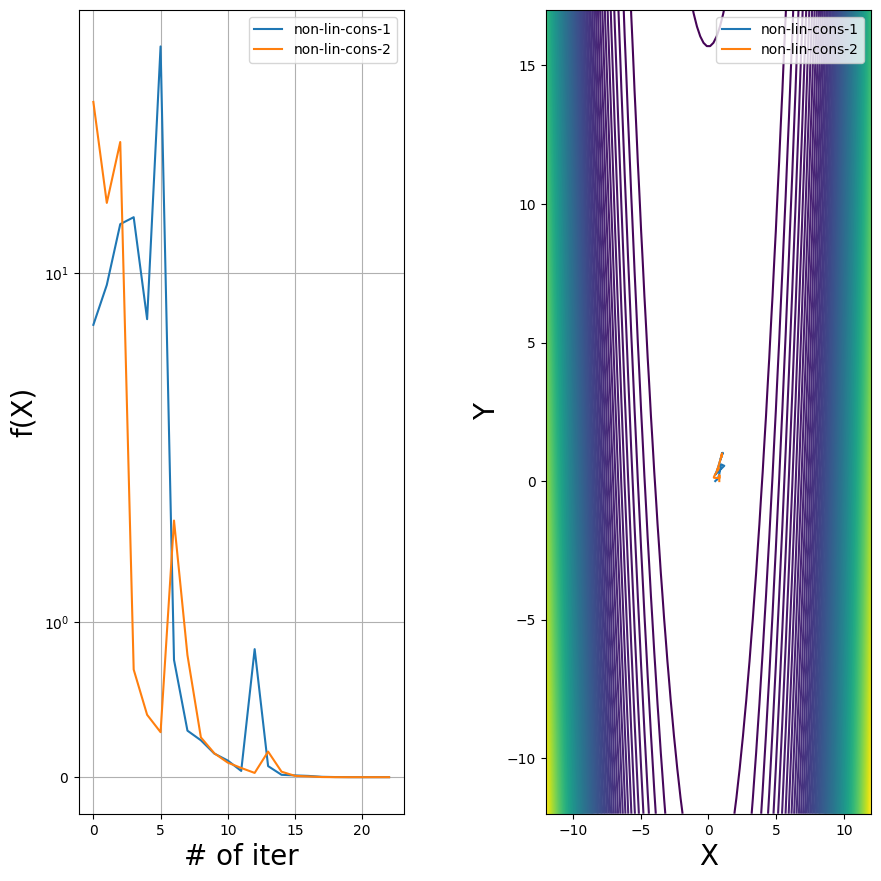

In [27]:
import numpy as np
from scipy.optimize import NonlinearConstraint
from funcs import f_rosenbrock
import descent
import visualization

reload(descent)


non_lin1 = NonlinearConstraint(lambda x: (x[0] - 1) ** 4 - x[1] ** 2 + 1, 0, 10)
non_lin2 = NonlinearConstraint(lambda x: np.sin(x[0]) * np.cos(x[1]),0.1, 0.8)

x0 = np.array([0.0, 0.0])


visualization.visualize_multiple_descent_2args_wh_time(
    {
        "non-lin-cons-1": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=non_lin1,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "non-lin-cons-2": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=non_lin2,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        )
    },
    f_rosenbrock,
)


Как можно видеть, ограничения необходимо выбирать осознано, учитвая особенности исследуемых функций. При этом, нелинейные ограничения дают большую свободу в выборе ограничения.

### Вывод

Таким образом, использование ограничений действительно может существенно ускорить схождение к экстремуму. А может и нет. Это зависит от корректности подобранных ограничений к конкретной задаче. 

# Заключение

